In [37]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Import necessary metrics from sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import glob
zip_path = '/content/drive/MyDrive/Weather prediction.zip'
extract_path = '/content/weather prediction'  # Destination folder
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction complete.


In [38]:


# Find all CSV files in the extracted directory
csv_files = glob.glob(os.path.join(extract_path, '*.csv'))
dfs = []  # Store all DataFrames

# Use enumerate to get both index (i) and value (csv_file)
for i, csv_file in enumerate(csv_files):
    print(f"\n📄 Processing: {csv_file}")
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(csv_file, encoding='latin1')
    except Exception as e:
        print(f"❌ Could not read {csv_file}: {e}")
        continue

    # Fill NaNs with mean for numeric columns
    df = df.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] else col)

    # Optionally rename columns to avoid duplicates using the index 'i'
    df.columns = [f"{i}_{col}" for col in df.columns]

    dfs.append(df)

# Concatenate all DataFrames horizontally (axis=1)
combined_df = pd.concat(dfs, axis=1)

# Show result
print("\n✅ Combined DataFrame:")
print(combined_df.head())


📄 Processing: /content/weather prediction/6_Riy_POWER_Point_Monthly_19810101_20251231_024d71N_046d69E_LST.csv

📄 Processing: /content/weather prediction/4_Mad_POWER_Point_Monthly_19810101_20251231_024d50N_039d60E_LST.csv

📄 Processing: /content/weather prediction/3_Kha_POWER_Point_Monthly_19810101_20251231_018d36N_042d71E_LST.csv

📄 Processing: /content/weather prediction/1_Bury_POWER_Point_Monthly_19810101_20251231_026d39N_043d93E_LST.csv

📄 Processing: /content/weather prediction/2_Hai_POWER_Point_Monthly_19810101_20251231_027d54N_041d69E_LST.csv

📄 Processing: /content/weather prediction/8_Tab_POWER_Point_Monthly_19810101_20251231_028d42N_036d61E_LST.csv

📄 Processing: /content/weather prediction/7_Sak_POWER_Point_Monthly_19810101_20251231_030d01N_040d15E_LST.csv

📄 Processing: /content/weather prediction/5_Mec_POWER_Point_Monthly_19810101_20251231_021d46N_039d79E_LST.csv

✅ Combined DataFrame:
   0_PARAMETER  0_YEAR  0_JAN  0_FEB  0_MAR  0_APR  0_MAY  0_JUN  0_JUL  \
0  PRECTOTCOR

In [39]:
numeric_df = combined_df.select_dtypes(include=[np.number])

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Define sequence length (e.g., 20 years = 20 time steps)
SEQ_LEN = 20
X, y = [], []

# Build sequences
for i in range(len(scaled_data) - SEQ_LEN):
    X.append(scaled_data[i:i+SEQ_LEN])
    y.append(scaled_data[i+SEQ_LEN])

X, y = np.array(X), np.array(y)

In [41]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LEN, X.shape[2])),
    Dense(X.shape[2])  # Output same shape as one time step
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=50, batch_size=16, verbose=1)

# Get predictions on the training data
y_pred = model.predict(X)

# Inverse transform y (true values) and y_pred (predictions) to original scale
y_true_unscaled = scaler.inverse_transform(y)
y_pred_unscaled = scaler.inverse_transform(y_pred)

# Calculate evaluation metrics using the unscaled values
mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_true_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_unscaled, y_pred_unscaled)

print(f"📊 Model Evaluation:")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

# Calculate MAE for each column
for i, col in enumerate(numeric_df.columns):
    # Check if the column index is within the bounds of the unscaled data
    if i < y_true_unscaled.shape[1]:
        mae_i = mean_absolute_error(y_true_unscaled[:, i], y_pred_unscaled[:, i])
        print(f"{col}: MAE = {mae_i:.4f}")
    else:
        print(f"Warning: Column index {i} out of bounds for unscaled data.")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3701
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0533
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0229
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0148
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0246
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0159
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0160
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0182
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0160
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0153
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0103
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0158
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0150
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165
Epoch 16/50
22/

In [32]:
future_input = scaled_data[-SEQ_LEN:].copy()
future_preds = []

for _ in range(20):  # Predict 20 years
    pred = model.predict(future_input[np.newaxis, ...], verbose=0)[0]
    future_preds.append(pred)
    future_input = np.vstack([future_input[1:], pred])  # Slide window

# Inverse transform predictions to original scale
future_preds_unscaled = scaler.inverse_transform(future_preds)

# Create DataFrame for forecast
future_df = pd.DataFrame(future_preds_unscaled, columns=numeric_df.columns)
future_df.index = np.arange(1, 21)  # Optional: year labels
print("\n📊 20-Year Forecast (All Variables):")
print(future_df)


📊 20-Year Forecast (All Variables):
         0_YEAR      0_JAN      0_FEB       0_MAR      0_APR      0_MAY  \
1   1978.140740  39.714433  51.641958   84.896760  67.223545  70.822071   
2   1979.177024  57.289040  57.238151  104.367932  69.176999  86.579265   
3   1978.863725  53.260331  59.434758   87.519542  62.237584  95.905162   
4   1979.492767  53.544349  59.207672   80.520477  63.480996  94.436124   
5   1980.452165  53.462334  58.199629   84.553998  68.110042  92.610373   
6   1981.528566  53.808281  57.725834   89.501369  72.289792  93.040600   
7   1982.643079  54.642266  57.851302   93.176267  75.607306  94.365688   
8   1983.747700  55.815638  58.471115   95.409323  78.109576  95.657583   
9   1984.824353  57.216669  59.461093   96.374471  79.870184  96.488809   
10  1985.867821  58.755601  60.702775   96.296093  80.985517  96.683683   
11  1986.878661  60.363629  62.102561   95.347193  81.528868  96.194354   
12  1987.861545  61.988922  63.588667   93.663019  81.559977  9

['0_YEAR', '0_JAN', '0_FEB', '0_MAR', '0_APR', '0_MAY', '0_JUN', '0_JUL', '0_AUG', '0_SEP', '0_OCT', '0_NOV', '0_DEC', '0_ANN', '0_Total Annual Rainfall', '0_Relative Humidity', '0_T emperature (¡æ)', '0_Surface Pressure (kPa)', '1_YEAR', '1_JAN', '1_FEB', '1_MAR', '1_APR', '1_MAY', '1_JUN', '1_JUL', '1_AUG', '1_SEP', '1_OCT', '1_NOV', '1_DEC', '1_ANN', '1_Total Annual Rainfall', '1_Relative Humidity', '1_T emperature (¡æ)', '1_Surface Pressure (kPa)', '2_YEAR', '2_JAN', '2_FEB', '2_MAR', '2_APR', '2_MAY', '2_JUN', '2_JUL', '2_AUG', '2_SEP', '2_OCT', '2_NOV', '2_DEC', '2_Total Annual Rainfall', '2_Relative Humidity', '2_T emperature (¡æ)', '2_Surface Pressure (kPa)', '3_YEAR', '3_JAN', '3_FEB', '3_MAR', '3_APR', '3_MAY', '3_JUN', '3_JUL', '3_AUG', '3_SEP', '3_OCT', '3_NOV', '3_DEC', '3_ANN', '3_      Year', '3_Total Annual Rainfall', '3_Relative Humidity', '3_T emperature (¡æ)', '3_Surface Pressure (kPa)', '4_YEAR', '4_JAN', '4_FEB', '4_MAR', '4_APR', '4_MAY', '4_JUN', '4_JUL', '4_AUG'

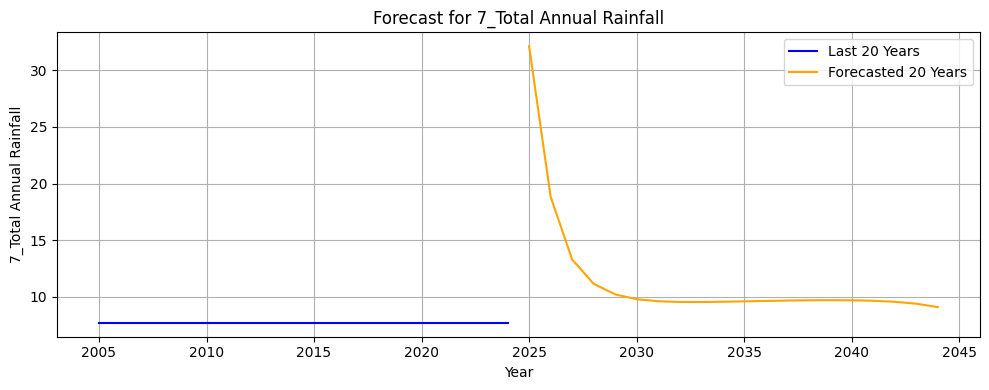

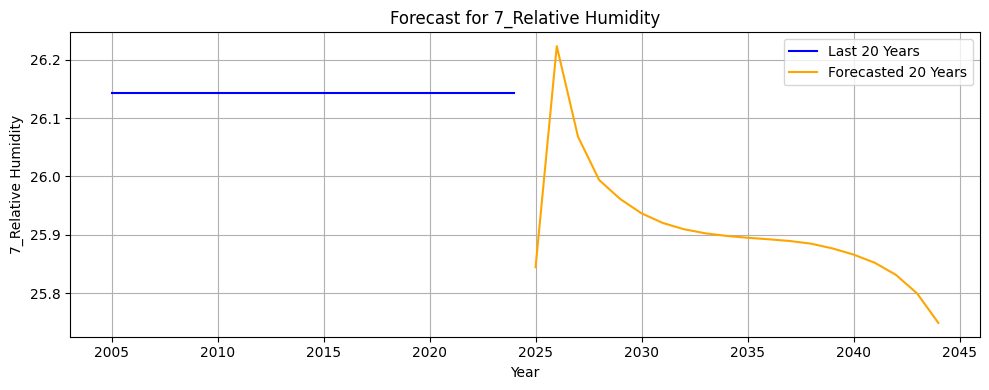

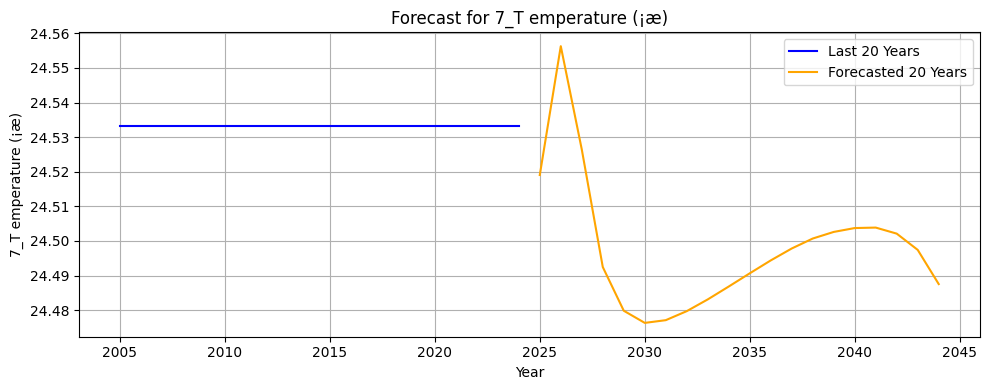

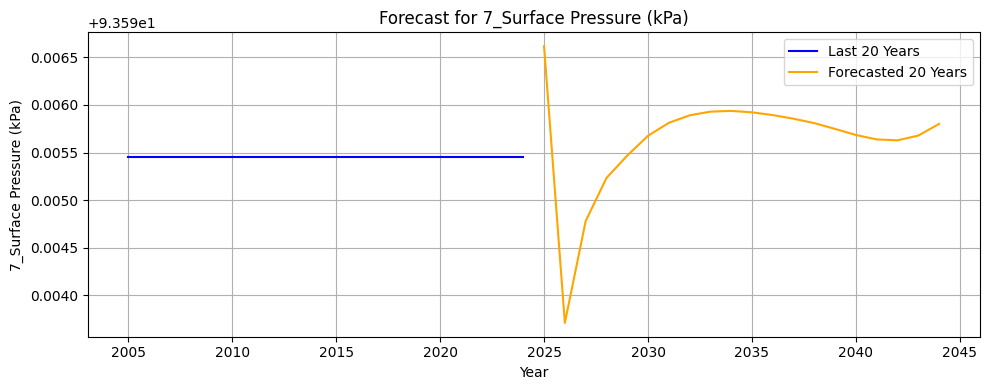

In [43]:
print(numeric_df.columns.tolist())
numeric_df.columns = numeric_df.columns.str.strip().str.replace('\u00a0', ' ', regex=True)
future_df.columns = future_df.columns.str.strip().str.replace('\u00a0', ' ', regex=True)
selected_cols = [
    '7_Total Annual Rainfall',
    '7_Relative Humidity',
    '7_T emperature (¡æ)',
    '7_Surface Pressure (kPa)'
]

# Get last 20 years of actuals
actual_last_20 = numeric_df[selected_cols].tail(20).reset_index(drop=True)

# Generate year labels: assuming last actual year is 2024
last_actual_year = 2024
actual_years = list(range(last_actual_year - 19, last_actual_year + 1))
future_years = list(range(last_actual_year + 1, last_actual_year + 21))

# Plot each selected column
for col in selected_cols:
    plt.figure(figsize=(10, 4))

    plt.plot(actual_years, actual_last_20[col], label='Last 20 Years', color='blue')
    plt.plot(future_years, future_df[col], label='Forecasted 20 Years', color='orange')

    plt.title(f"Forecast for {col}")
    plt.xlabel("Year")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()